# Bolus Tracking

Use this notebook for single animals, otherwise run it in batch from **GLUT1_Analysis**

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import MRIhelperfunctions as h
import MRIhelperfunctions
from MRIhelperfunctions import Settings
from imp import importlib
import fnmatch
import papermill as pm

import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline  

In [18]:
importlib.reload(h)
import MRIhelperfunctions as h
from MRIhelperfunctions import Settings

In [3]:
# Default Parameters (to run script independently)
folders = {}
folders['raw'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata'
folders['main'] = os.path.dirname(folders['raw'])
folders['analysis'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis'
folders['animal'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/20180604_101508_Glut1_2_2'
folders['excel'] = 'Animal_Scan_IDs.xlsx'


animal = 'glut1_male1'


info = h.getinfo(folders)
info

,glut1_male1,glut1_male2,glut1_f10wks1,glut1_f10wks2,glut1_f10wks3,glut1_f10wks4,glut1_f10wks5,glut1_f10wks6,glut1_f8wks1,glut1_f8wks2,glut1_f8wks3,glut1_f8wks4,glut1_f8wks5,glut1_f8wks6,glut1_f8wks7,glut1_f6wks2,glut1_f6wks1
scan,,,,,,,,,,,,,,,,,
Gd DCE,6,8,6,5,5,8,5,5,7,5,6,6,8,8,6,5,5
Angio pre,8,9,7,6,6,9,6,6,8,6,9,8,9,9,8,6,6
Angio post,12,12,11,9,9,13,10,11,12,11,12,12,16,13,12,9,10
Endorem DCE,11,11,10,8,8,12,9,10,10,10,11,11,15,12,11,8,9
Diamox,15,14,13,11,13,15,12,13,14,13,16,17,20,16,14,11,13
folder,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...


In [16]:
# additional Script specific parameters

# info = pd.read_json(info)  #<-- dont run this line in single animal mode

folders['template'] = os.path.join(folders['main'], 'Templates', 'BolusTracking.nii' ) # from animal glut1_male1
folders['in'] = os.path.join(folders['analysis'], animal)
folders['out'] = os.path.join(folders['in'], 'BolusTracking')

if not os.path.exists(folders['out']):
    os.makedirs(folders['out'] )

In [6]:
scans={}
scans['number'] = int(info.loc['Endorem DCE', animal])

scans['raw'] = os.path.join(folders['in'], f"X{scans['number']}P1.nii")


raw = nib.load(scans['raw'])
print(f'check if these dimensions make sense:  pre: {raw.shape}')

check if these dimensions make sense:  pre: (80, 35, 10, 1200)


In [21]:
# cut out a single repetition
scans['single'] = f"{folders['out']}/single_timepoint.nii"
h.runAFNI(f"3dTcat -prefix {scans['single']} {scans['raw']}'[0]'")

# cut off first 10 points
scans['cut'] = os.path.join(folders['out'], f"{scans['number']}_cut.nii")
h.runAFNI(f"3dTcat -prefix {scans['cut']} {scans['raw']}'[10..$]'")

# coregistration
scans['single_coreg'], scans['coreg'] = h.simple_coreg(folders['template'], scans['single'], scans['cut'], folders['out'])

3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/single_timepoint.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X11P1.nii'[0]'
3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/11_cut.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X11P1.nii'[10..$]'
3dAllineate -base /home/aic/BigHDD/MR_DATA/GLUT1/Templates/BolusTracking.nii -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/single_timepoint.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/A_coreg.nii -cost ls -zclip -interp quintic -final wsinc5 -twopass -twoblur 2 -fineblur 0.5 -nmatch 80% -conv 0.01 -1Dparam_save /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/1dparams.1D
3dAllineate -1Dparam_apply /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/1dparams.1D -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/BolusTracking/11_cut.nii -prefix /home/aic/BigHDD/

In [112]:
img = nib.load(scans['coreg'])
data = img.get_fdata()
hdr = img.header
print(hdr)


dimensions = Settings()
dimensions.t_res = hdr['pixdim'][4]

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [   4   80   35   10 1190    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.2        0.2        0.50591666 0.4        0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 9
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.70710677
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -8.455814
qoffset_y       :

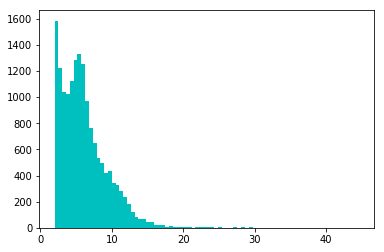

In [25]:
data_averaged = np.mean(data,axis=3)  # average time points

threshold = 2

plt.hist(data_averaged.flatten(), bins=80, color='c', range=(threshold, np.max(data)))
plt.show()

In [35]:
data.shape

data_reshaped = data.reshape(-1, data.shape[-1])

In [36]:
data_reshaped.shape

(28000, 1190)

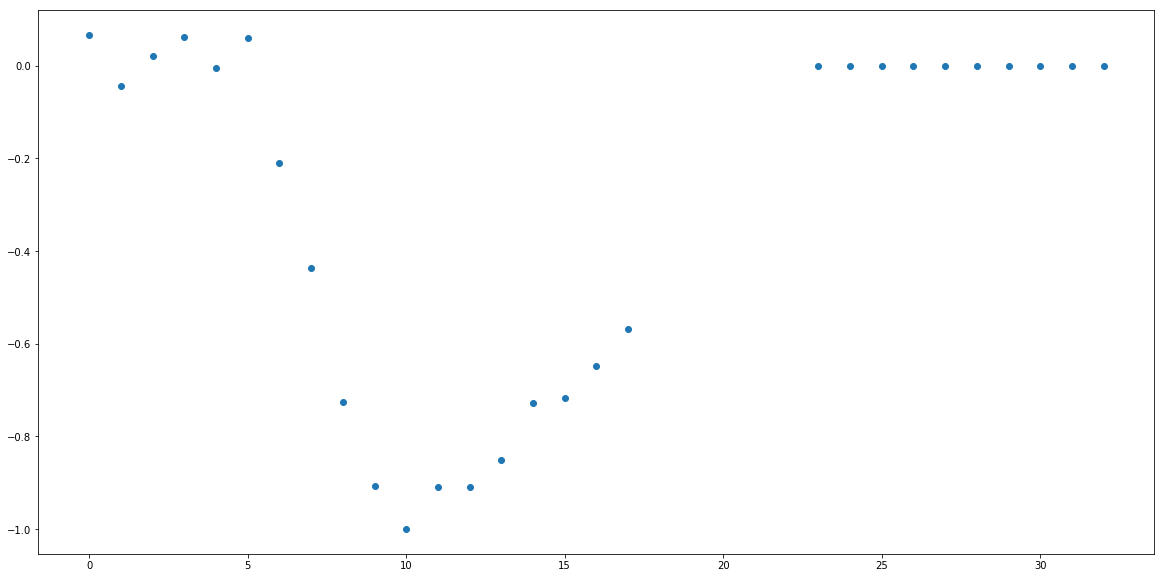

In [104]:
threshold=7

for voxel in data_reshaped:
        if np.mean(voxel) > threshold:
            x=voxel
            
plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(y,'o')
# plt.plot(x[0:],'o')
plt.show()

In [102]:
y = preparesignal(x, start_point)

In [93]:
end_point

439

In [92]:
np.mean(x[:start_point])


end_point = int(np.argwhere(x[np.argmin(x):] >= 0.9 * np.mean(x[np.argmin(x)+8:np.argmin(x)+100]))[0]) + np.argmin(x)

In [124]:
def preparesignal(x,start_point):
    bsl = np.mean(x[:start_point-2])
    x[end_point+1:] = bsl
    x = x-bsl
    x = x/np.max(np.abs(x))
    x[end_point:end_point+5]=np.nan
    x = -x[start_point-5:end_point+15]
    return x
    
start_point = np.argmin(x) - 5
# end_point in words: first point after the absolute minimum that reaches 90% of post-injection baseline (first 100 points) level
end_point = int(np.argwhere(x[np.argmin(x):] >= 0.9 * np.mean(x[np.argmin(x)+8:np.argmin(x)+100]))[0]) + np.argmin(x)

In [116]:
signal = preparesignal(x,start_point)

signal.size

33

In [125]:
from lmfit.models import ExpressionModel


script = """
def gammavar(ymax, tmax, a, x, t0):
    x_input = x * (x > t0) + (t0 + tmax) * (x <= t0)
    return (exp(log(ymax)+a*(1+log((x_input-t0)/tmax)-(x_input-t0)/tmax))) * (x > t0)
"""


model = ExpressionModel(f'gammavar(ymax0, tmax0, a0, x, t0)',
                        init_script=script,
                        intependent_vars=['x'], nan_policy='propagate')
    
params = model.make_params()
params['ymax0'].set(value=0.5, min=0, max=1)
params['tmax0'].set(value=2, min=1, max=5)
params['a0'].set(1, min=0.05, max=5)
params['t0'].set(value=2, min=1, max=3)

signal = preparesignal(x,start_point)
time = np.arange(0,signal.size)/dimensions.t_res


result = model.fit(signal, params, x=time)




[[Model]]
    Model(_eval, intependent_vars='['x']')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 33
    # variables        = 4
    chi-square         = nan
    reduced chi-square = nan
    Akaike info crit   = nan
    Bayesian info crit = nan
[[Variables]]
    ymax0:  0.50000000 (init = 0.5)
    tmax0:  2.00000000 (init = 2)
    a0:     1.00000000 (init = 1)
    t0:     2.00000001 (init = 2)



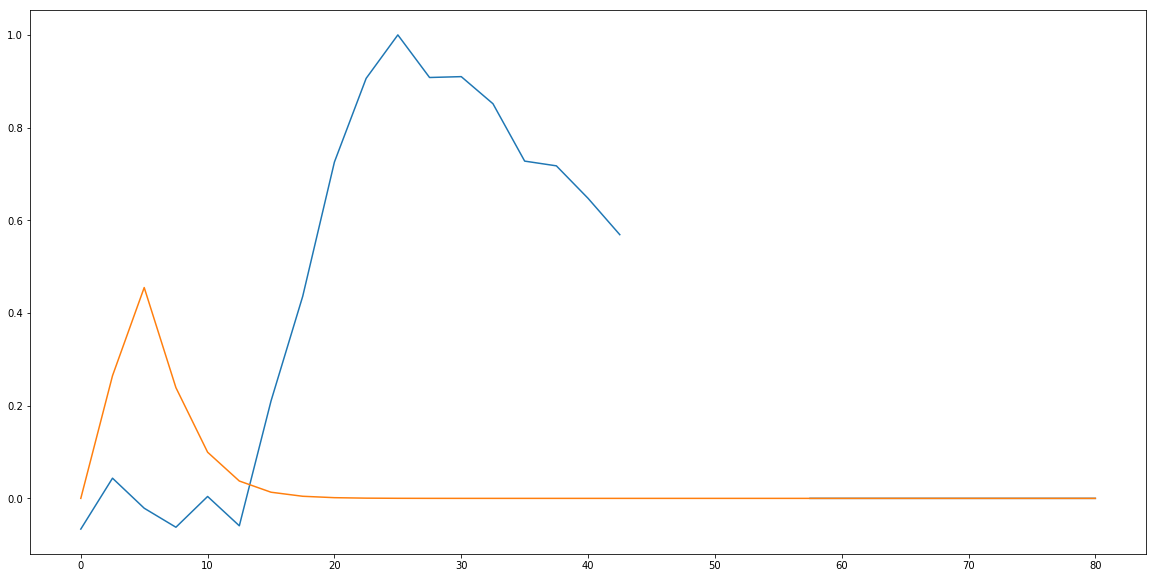

In [126]:
print(result.fit_report())
plt.figure(figsize=[20,10])
plt.plot(time, signal)
plt.plot(time, result.best_fit)